In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# lA ID de la GPU a usar, puede ser desde 0 hasta las N GPU's. Si es -1 significa que es en la CPU
os.environ["CUDA_VISIBLE_DEVICES"]="1";

# Importacion de librerias

In [9]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import tensorflow as tf
import random
import IPython.display as display
from random import randint

# Configuraciones de TensorFlow

### Configuracion de TensorFlow 2.0

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

### Configuracion de TensorFlow 1.0

In [4]:
config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True

### Modo eagerly

In [5]:
#Comprobar que estoy ejecutandome en modo eagerly
tf.executing_eagerly()

False

# Carga de Datos

In [11]:
root_path = "/home/jefelitman/DataSets/ucf101"
root_path

'/home/jefelitman/DataSets/ucf101'

In [48]:
splits = sorted(os.listdir(root_path))
splits

['split_1', 'split_2', 'split_3']

In [49]:
modes = ["train","test"]

### Voy a empezar cargando los datos de un split para train

In [60]:
clases_path = os.path.join(root_path,"split_1",modes[0])

clases = sorted(os.listdir(clases_path))
clase_a_numero = dict((name, index) for index,name in enumerate(clases))
len(clases)

101

In [70]:
clase = random.choice(clases)
videos_path = os.path.join(clases_path,clase)
videos = sorted(os.listdir(videos_path))
video = random.choice(videos)
frames_path = os.path.join(videos_path,video)
frames = sorted(os.listdir(frames_path))
frame = random.choice(frames)
frames_path

'/home/jefelitman/DataSets/ucf101/split_1/train/PlayingDhol/v_playingdhol_g24_c04'

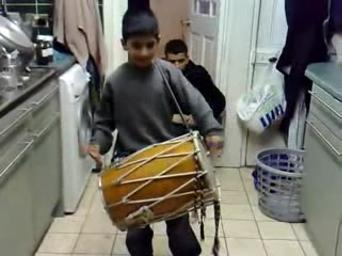

In [71]:
frame_path = os.path.join(frames_path,frame)
display.display(display.Image(frame_path))

### Funciones para la carga de los videos

In [ ]:
def get_frames_data(filename, num_frames_per_clip=16):
    ''' Given a directory containing extracted frames, return a video clip of
    (num_frames_per_clip) consecutive frames as a list of np arrays '''
    ret_arr = []
    s_index = 0
    for parent, dirnames, filenames in os.walk(filename):
    if(len(filenames)<num_frames_per_clip):
        return [], s_index
    filenames = sorted(filenames)
    s_index = random.randint(0, len(filenames) - num_frames_per_clip)
    for i in range(s_index, s_index + num_frames_per_clip):
        image_name = str(filename) + '/' + str(filenames[i])
        img = Image.open(image_name)
        img_data = np.array(img)
        ret_arr.append(img_data)
    return ret_arr, s_index

In [ ]:
def read_clip_and_label(filename, batch_size, start_pos=-1, num_frames_per_clip=16, crop_size=112, shuffle=False):
    lines = open(filename,'r')
    read_dirnames = []
    data = []
    label = []
    batch_index = 0
    next_batch_start = -1
    lines = list(lines)
    np_mean = np.load('crop_mean.npy').reshape([num_frames_per_clip, crop_size, crop_size, 3])
    # Forcing shuffle, if start_pos is not specified
    if start_pos < 0:
        shuffle = True
    if shuffle:
        video_indices = range(len(lines))
        random.seed(time.time())
        random.shuffle(video_indices)
    else:
        # Process videos sequentially
        video_indices = range(start_pos, len(lines))
    for index in video_indices:
        if(batch_index>=batch_size):
            next_batch_start = index
            break
        line = lines[index].strip('\n').split()
        dirname = line[0]
        tmp_label = line[1]
        if not shuffle:
            print("Loading a video clip from {}...".format(dirname))
        tmp_data, _ = get_frames_data(dirname, num_frames_per_clip)
        img_datas = [];
        if(len(tmp_data)!=0):
            for j in xrange(len(tmp_data)):
                img = Image.fromarray(tmp_data[j].astype(np.uint8))
                if(img.width>img.height):
                    scale = float(crop_size)/float(img.height)
                    img = np.array(cv2.resize(np.array(img),(int(img.width * scale + 1), crop_size))).astype(np.float32)
                else:
                    scale = float(crop_size)/float(img.width)
                    img = np.array(cv2.resize(np.array(img),(crop_size, int(img.height * scale + 1)))).astype(np.float32)
                crop_x = int((img.shape[0] - crop_size)/2)
                crop_y = int((img.shape[1] - crop_size)/2)
                img = img[crop_x:crop_x+crop_size, crop_y:crop_y+crop_size,:] - np_mean[j]
                img_datas.append(img)
            data.append(img_datas)
            label.append(int(tmp_label))
            batch_index = batch_index + 1
            read_dirnames.append(dirname)

    # pad (duplicate) data/label if less than batch_size
    valid_len = len(data)
    pad_len = batch_size - valid_len
    if pad_len:
        for i in range(pad_len):
            data.append(img_datas)
            label.append(int(tmp_label))

    np_arr_data = np.array(data).astype(np.float32)
    np_arr_label = np.array(label).astype(np.int64)

    return np_arr_data, np_arr_label, next_batch_start, read_dirnames, valid_len

### Como cargar los videos usando la libreria de tensorflow

In [ ]:
#Forma de cargar los videos para usarlos como dataset pero ocupa mucha memoria, entonces se va hacer buffering con tensor
videos = []
for video_path in videos_rgb_path:
    video = []
    for frame_path in sorted(list(video_path.glob('*'))):
        frame_raw = tf.io.read_file(str(frame_path))
        frame_tensor = tf.image.decode_image(frame_raw, channels=3)
        frame_tensor = tf.image.resize(frame_tensor,[128,171])
        frame_tensor = seleccionar_cuadro_aleatorio(frame_tensor, 112)
        video.append(frame_tensor)
    video = tf.convert_to_tensor(video)
    video = seleccionar_extension_temporal(video, 16)
    videos.append(video)
videos = tf.convert_to_tensor(videos)

In [15]:
def seleccionar_cuadro_aleatorio(imagen, nueva_dimension):
    pos_y = randint(0,imagen.shape[0].value - nueva_dimension)
    pos_x = randint(0,imagen.shape[1].value - nueva_dimension)
    return imagen[pos_y : pos_y + nueva_dimension , pos_x : pos_x + nueva_dimension, :]

In [16]:
def seleccionar_extension_temporal(video, nro_frames):
    extension = randint(0,video.shape[0].value - nro_frames)
    return video[extension : extension + nro_frames, : , :, :]

In [ ]:
#Funcion sin ser usada aun
def procesar_frame(frame_path):
    frame_raw = tf.io.read_file(str(frame_path))
    frame_tensor = tf.image.decode_image(frame_raw, channels=3)
    frame_tensor = tf.image.resize(frame_tensor,[128,171])
    return frame_tensor

In [17]:
def cargar_preprocesar_video(video_path):
    video = []
    for frame_path in sorted(list(pathlib.Path(video_path.numpy()).glob('*'))):
        frame_raw = tf.io.read_file(str(frame_path))
        frame_tensor = tf.image.decode_image(frame_raw, channels=3)
        frame_tensor = tf.image.resize(frame_tensor,[128,171])
        frame_tensor = seleccionar_cuadro_aleatorio(frame_tensor, 112)
        video.append(frame_tensor)
    video = tf.convert_to_tensor(video)
    video = seleccionar_extension_temporal(video, 16)
    return video

### Creacion de los datasets de TensorFlow

In [18]:
#Construccion del dataset a partir de los path y cargar los datos usando prefetch
videos_rgb_path_ds = tf.data.Dataset.from_tensor_slices(videos_rgb_path)
videos_rgb_path_ds

<TensorSliceDataset shapes: (), types: tf.string>

In [19]:
videos_ds = videos_rgb_path_ds.map(cargar_preprocesar_video, num_parallel_calls=tf.data.experimental.AUTOTUNE)

AttributeError: in converted code:

    <ipython-input-17-f22c65689ba7>:3 cargar_preprocesar_video  *
        for frame_path in sorted(list(pathlib.Path(video_path.numpy()).glob('*'))):

    AttributeError: 'Tensor' object has no attribute 'numpy'


### Convertir los tensores a texto con tf.data

In [ ]:
directories_ds = tf.data.Dataset.list_files(videos_rgb_path[0]+"/*")

for video in directories_ds:
    print(video)

In [ ]:
videos_rgb_path_ds = tf.data.TextLineDataset(videos_rgb_path_ds)
videos_rgb_path_ds

In [ ]:
for video in videos_rgb_path_ds:
    frames = tf.data.TextLineDataset(video)
    #print(frames)
    #print(frames.list_files("*"))
    for frame in frames.list_files("*"):
        print(frame)
    break

In [ ]:
tf.data.get_output_stype(videos_rgb_path_ds)

In [ ]:
videos_rgb_path_ds.list_files("*")

### Listar directorios usando la libreria tf.io.gfile

In [ ]:
for elemento in videos_rgb_path_ds:
    print(elemento)
    #print(tf.io.gfile.listdir(elemento))
    break

In [ ]:
https://stackoverflow.com/questions/44416764/loading-folders-of-images-in-tensorflow
https://github.com/hx173149/C3D-tensorflow
https://gist.github.com/tomrunia/7ef5d40639f2ae41fb71d3352a701e4a
https://github.com/ferreirafabio/video2tfrecord
https://stackoverflow.com/questions/42978731/video-frames-as-inputs-to-the-tensorflow-graph

In [ ]:

tf.io.gfile.listdir(tf.constant("../DataSets/UCF101/frames/v_PlayingPiano_g24_c04"))

In [ ]:
videos_ds = videos_rgb_path_ds.map(cargar_preprocesar_video, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [ ]:
etiquetas_ds = tf.data.Dataset.from_tensor_slices(clases_videos)
etiquetas_ds

In [ ]:
tf.version.VERSION

# Red Neuronal

In [ ]:
from LTC import LTC



model = LTC(
    entrada = None,
    etiquetas = None,
    num_clases = None,
    batch_size = 30,
    dropout = 0.5,
    entramiento = True):

logging_hook = tf.train.LoggingTensorHook(
      tensors={'step': model.global_step,
               'loss': model.cost,
               'precision': precision},
      every_n_iter=100)

training_session = tf.train.MonitoredTrainingSession(
    checkpoint_dir="./Checkpoints",
      hooks=[logging_hook, _LearningRateSetterHook()],
      chief_only_hooks=[summary_hook],
      # Since we provide a SummarySaverHook, we need to disable default
      # SummarySaverHook. To do that we set save_summaries_steps to 0.
      save_summaries_steps=0,
      config=config
)

In [ ]:
https://www.math.purdue.edu/~nwinovic/slides/Getting_Started_with_TensorFlow_II.pdf